In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import Model, Sequential

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

from keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.17.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
df = pd.read_csv('./一教_1.csv')

In [6]:
print(df)

     human1_part0_x  human1_part0_y  human1_part1_x  human1_part1_y  \
0         -1.000000       -1.000000        0.643519        0.358696   
1          0.490741        0.331522        0.486111        0.364130   
2          0.490741        0.331522        0.486111        0.364130   
3          0.490741        0.331522        0.486111        0.364130   
4         -1.000000       -1.000000        0.638889        0.353261   
..              ...             ...             ...             ...   
460        0.356481        0.494565        0.388889        0.500000   
461        0.356481        0.494565        0.388889        0.500000   
462        0.356481        0.494565        0.388889        0.500000   
463        0.361111        0.494565        0.388889        0.500000   
464        0.361111        0.494565        0.388889        0.500000   

     human1_part2_x  human1_part2_y  human1_part3_x  human1_part3_y  \
0          0.657407        0.358696        0.666667        0.413043   
1    

<Axes: >

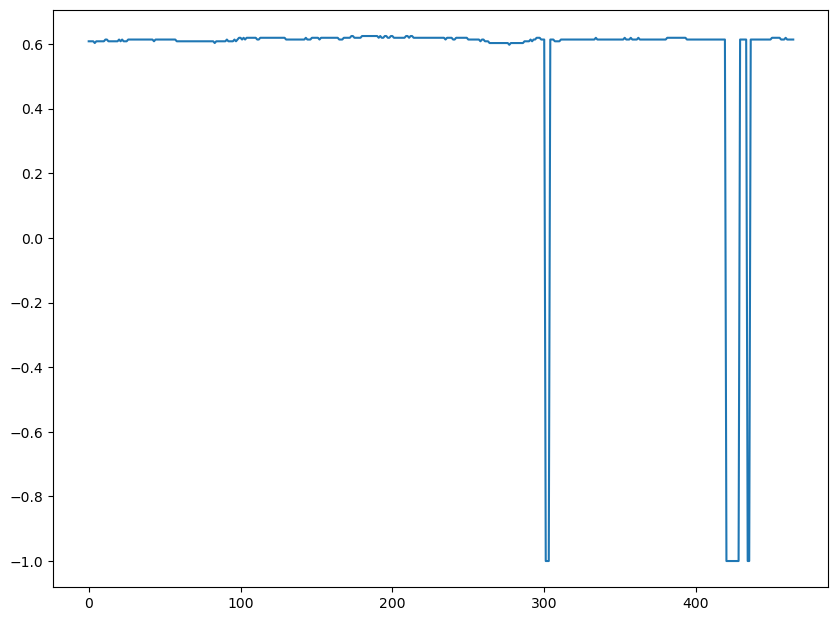

In [7]:
df['human1_part10_y'].plot()

<Axes: >

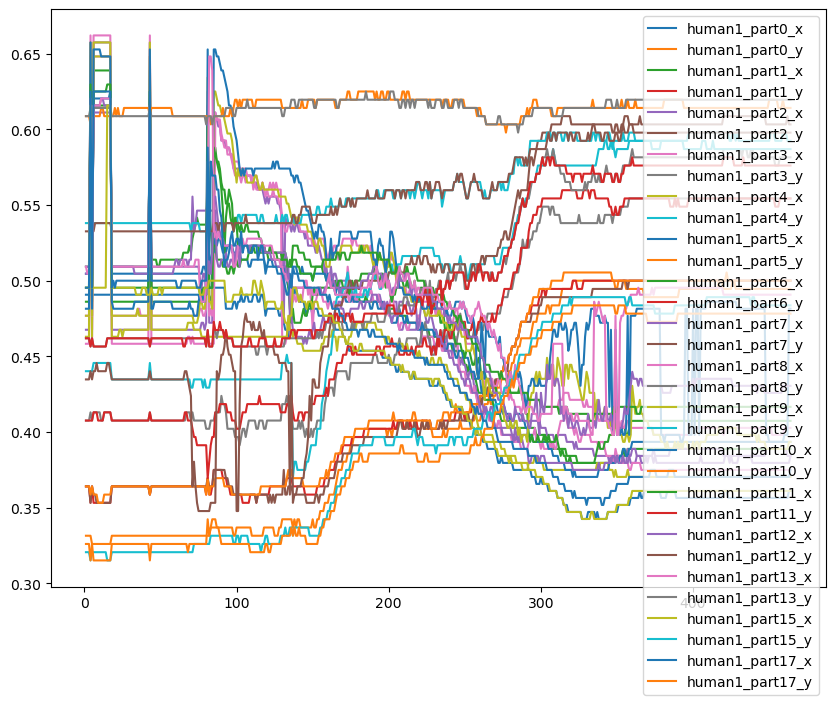

In [8]:
df2 = df.sum(axis=0)
df1 = df[df2[df2 > 0].index].replace(-1, np.nan).fillna(method = 'ffill')[1:]
df1.plot()

<Axes: >

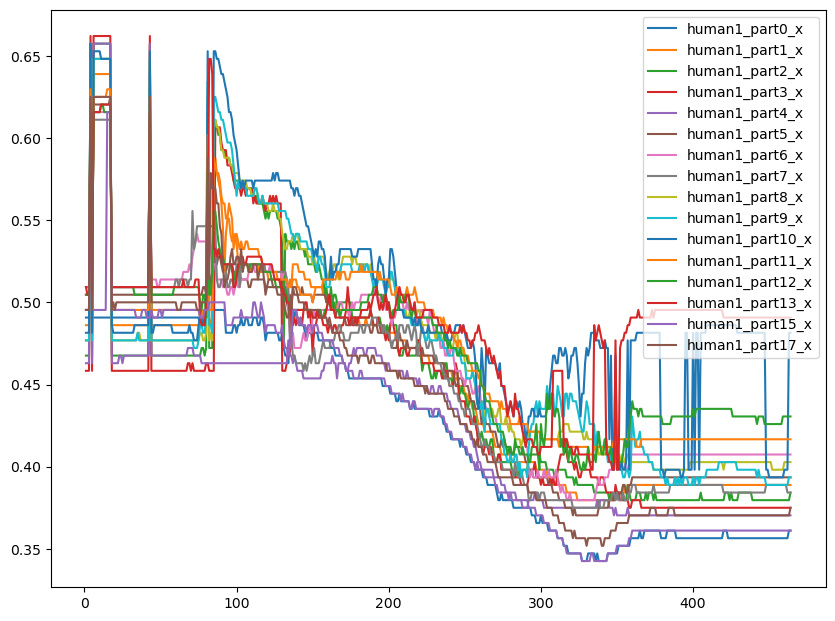

In [9]:
df1[df1.columns[df1.columns.str.endswith('x')]].plot()

<Axes: >

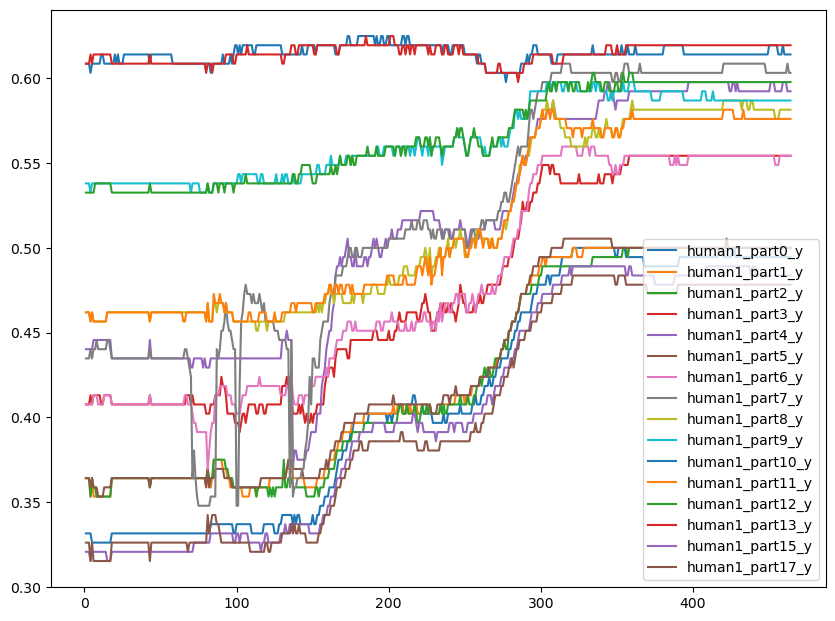

In [10]:
df1[df1.columns[df1.columns.str.endswith('y')]].plot()

In [12]:
# データの一部を使って学習
train_df = df1.loc[:300]
val_df = df1.loc[300:400]
test_df = df1.loc[400:]

# 別なデータファイルを使って学習（train:学習用, val:確認用, test:ベンチマーク）
# train_df = pd.read_csv('./一教_1.csv')
# val_df = pd.read_csv('./一教_1.csv')
# test_df = pd.read_csv('./一教_1.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(300, 32) (101, 32) (65, 32)


In [13]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='human1_part0_y', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [14]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [15]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
print(column_indices)

{'human1_part0_x': 0, 'human1_part0_y': 1, 'human1_part1_x': 2, 'human1_part1_y': 3, 'human1_part2_x': 4, 'human1_part2_y': 5, 'human1_part3_x': 6, 'human1_part3_y': 7, 'human1_part4_x': 8, 'human1_part4_y': 9, 'human1_part5_x': 10, 'human1_part5_y': 11, 'human1_part6_x': 12, 'human1_part6_y': 13, 'human1_part7_x': 14, 'human1_part7_y': 15, 'human1_part8_x': 16, 'human1_part8_y': 17, 'human1_part9_x': 18, 'human1_part9_y': 19, 'human1_part10_x': 20, 'human1_part10_y': 21, 'human1_part11_x': 22, 'human1_part11_y': 23, 'human1_part12_x': 24, 'human1_part12_y': 25, 'human1_part13_x': 26, 'human1_part13_y': 27, 'human1_part15_x': 28, 'human1_part15_y': 29, 'human1_part17_x': 30, 'human1_part17_y': 31}


In [16]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['human1_part0_y']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['human1_part0_y'])

In [17]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [18]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1134 - mean_absolute_error: 0.2938 - val_loss: 0.0326 - val_mean_absolute_error: 0.1685
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - mean_absolute_error: 0.1432 - val_loss: 0.0313 - val_mean_absolute_error: 0.1669
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - mean_absolute_error: 0.1050 - val_loss: 0.0084 - val_mean_absolute_error: 0.0530
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0064 - val_mean_absolute_error: 0.0383
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - mean_absolute_error: 0.0394 - val_loss: 0.0107 - val_mean_absolute_error: 0.0873
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0362 - val_loss: 0.0052 - val_mean_absolute_error: 0.0367
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0334 - val_loss: 0.0062 - val_mean_

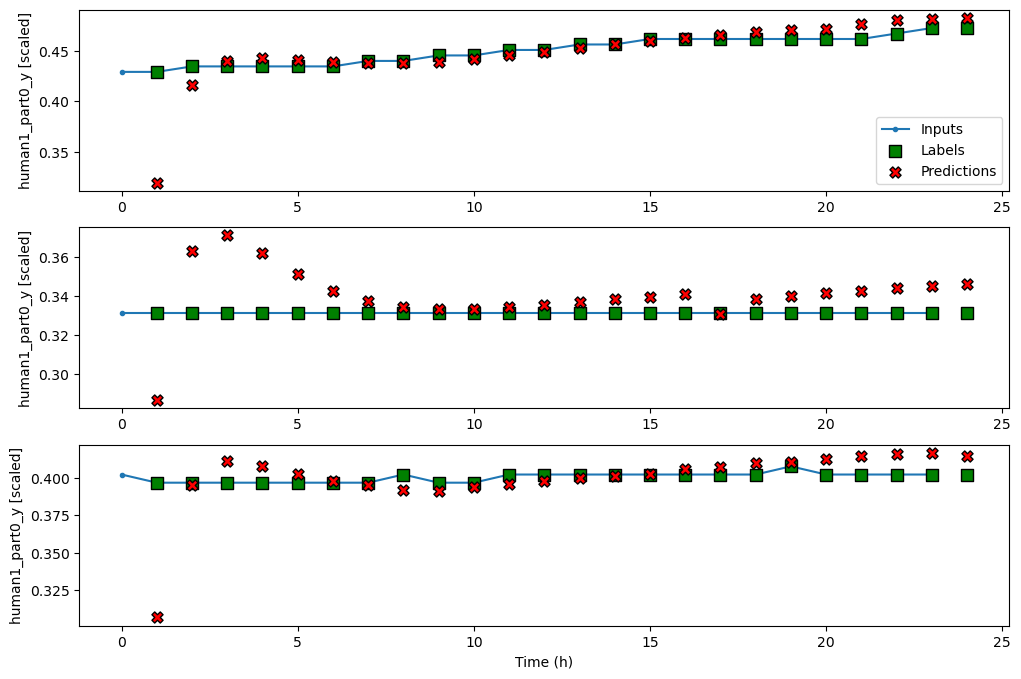

In [19]:
wide_window.plot(lstm_model)

In [20]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=train_df.columns) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=train_df.columns)

In [21]:
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [22]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 32)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2395 - mean_absolute_error: 0.4287 - val_loss: 0.1524 - val_mean_absolute_error: 0.3310
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1206 - mean_absolute_error: 0.2842 - val_loss: 0.0896 - val_mean_absolute_error: 0.2513
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0643 - mean_absolute_error: 0.2006 - val_loss: 0.0530 - val_mean_absolute_error: 0.1933
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - mean_absolute_error: 0.1326 - val_loss: 0.0329 - val_mean_absolute_error: 0.1519
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - mean_absolute_error: 0.1003 - val_loss: 0.0221 - val_mean_absolute_error: 0.1214
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mean_absolute_error: 0.0719 - val_loss: 0.0161 - val_mean_absolute_error: 0.1042
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0523 - val_loss: 0.0140 - val_mean_

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

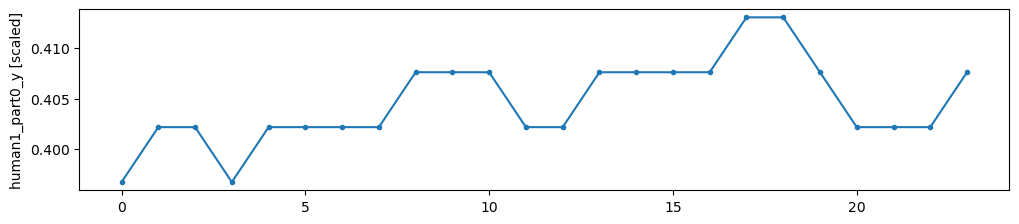

In [23]:
mo_wide_window.plot(model=mo_lstm_model)

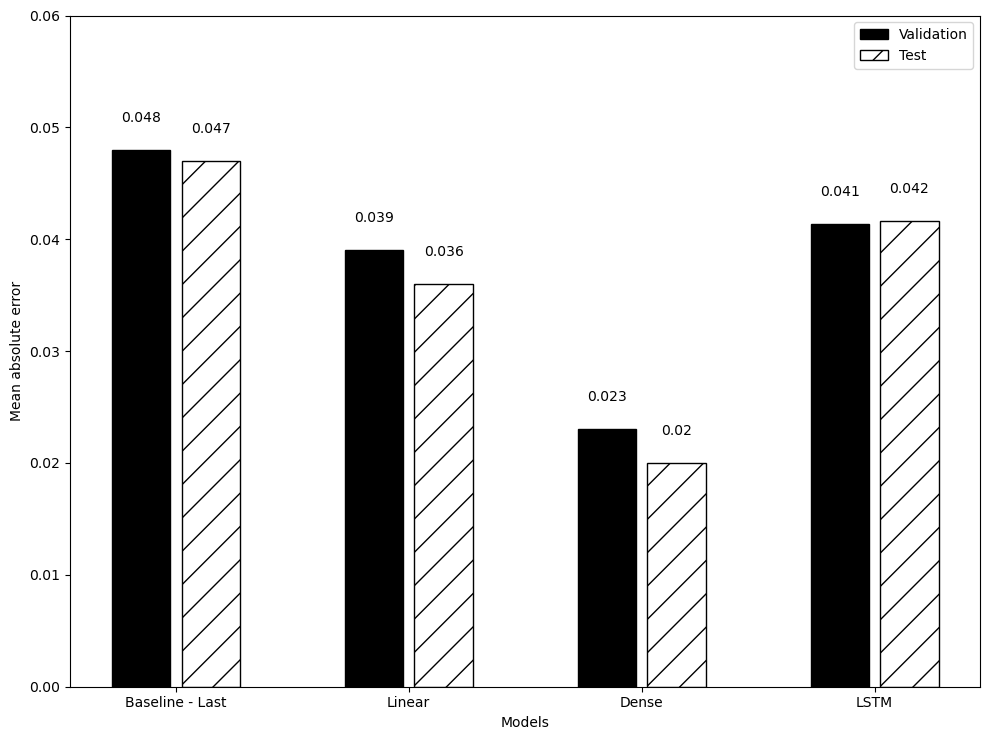

In [24]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()